In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import sys
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import sleep, gmtime, strftime
import json
import time

In [3]:
!pip install sagemaker-experiments 
from sagemaker.analytics import ExperimentAnalytics
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.


['appledatabucket-123/Apple/1', 'appledatabucket-123/Apple/11', 'appledatabucket-123/Apple/12', 'appledatabucket-123/Apple/13', 'appledatabucket-123/Apple/14', 'appledatabucket-123/Apple/15', 'appledatabucket-123/Apple/16', 'appledatabucket-123/Apple/17', 'appledatabucket-123/Apple/18', 'appledatabucket-123/Apple/19', 'appledatabucket-123/Apple/2', 'appledatabucket-123/Apple/20', 'appledatabucket-123/Apple/21', 'appledatabucket-123/Apple/22', 'appledatabucket-123/Apple/23', 'appledatabucket-123/Apple/24', 'appledatabucket-123/Apple/25', 'appledatabucket-123/Apple/3', 'appledatabucket-123/Apple/4', 'appledatabucket-123/Apple/5', 'appledatabucket-123/Apple/6', 'appledatabucket-123/Apple/7', 'appledatabucket-123/Apple/8', 'appledatabucket-123/Apple/9']


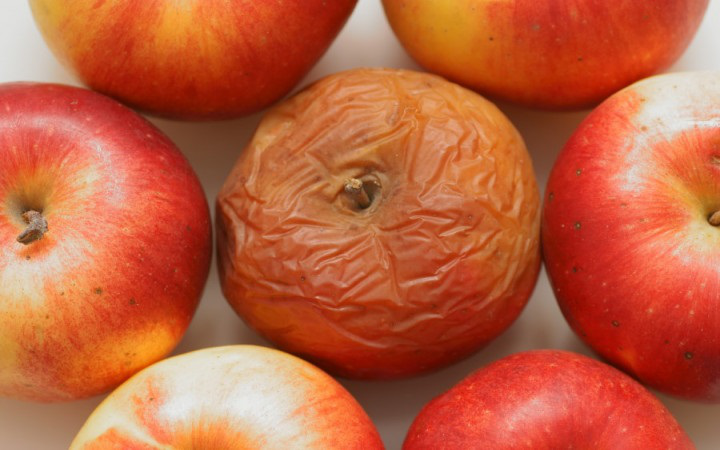

In [5]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

# To List 5 files in your accessible bucket
print(fs.ls("s3://appledatabucket-123/Apple/"))

# open it directly
f = fs.open("s3://appledatabucket-123/Apple/1/1.jpg")
display(Image.open(f))

# for p in fs.ls('s3://appledatabucket/Apple/'):
#     print(p.split("/")[2])

In [7]:
# Defining the Execution Role so that we could start Training :

from sagemaker import get_execution_role
role = get_execution_role()
role

'arn:aws:iam::516003265142:role/service-role/AmazonSageMaker-ExecutionRole-20220727T095620'

In [8]:
from sagemaker.sklearn.processing import SKLearnProcessor
sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=role,
                                     instance_type='ml.c4.xlarge',
                                     instance_count=1)

In [9]:
!pygmentize ImageSegmentation.py

# Importing Packages :
import os
import sys
import boto3
import subprocess
import configparser


# Installing all the Pack Required :
subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "tifffile"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "patchify"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "h5py==2.10.0"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "segmentation-models==1.0.1"])

# Importing nessary packages:
import io
import argparse
import tensorflow
import numpy as np
from numpy import asarray
from tensorflow import keras
from patchify import patchify
import segmentation_models as sm
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# The training code will be contained in a main gaurd (if __name__ == '__main__') so SageMaker will execute the code 

In [13]:
#Defining the Tensorflow Estimator For Training:

from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='ImageSegmentation.py',         # Python source file which should be executed as the entry point to model hosting.
                          role=role,                           # An AWS IAM role (either name or full ARN).
                          train_instance_count=1,              # Number of EC2 instances to use.
                          train_instance_type='ml.m4.xlarge',  # Type of EC2 instance to use.
                          framework_version='1.15',            # TensorFlow version you want to use for executing your model training code.
                          py_version='py3',                   # Python version you want to use for executing your model training code.          
                          script_mode=True,                    # Script Mode Enable to create Docker File Automaticaly.
                         )

In [14]:
# Training the Model in the Sagemaker Instance:
tf_estimator.fit()

INFO:sagemaker:Creating training-job with name: tensorflow-training-2022-09-02-05-40-06-742


2022-09-02 05:40:07 Starting - Starting the training job......
2022-09-02 05:40:46 Starting - Preparing the instances for training.........
2022-09-02 05:42:14 Downloading - Downloading input data...
2022-09-02 05:42:48 Training - Downloading the training image..WARNING:tensorflow:From /usr/local/lib/python3.6/site-packages/tensorflow_core/__init__.py:1473: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.
2022-09-02 05:43:16,831 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2022-09-02 05:43:16,841 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-02 05:43:17,813 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-02 05:43:17,841 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-02 05:43:17,862 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)

In [15]:
# Customising The End Point so that it can be easily accessed:

import time
py_torch_endpoint = 'FruitImageSegmentation-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [ ]:
# Deployment of the Trained Model :
# This will creating an endpoint which is a fully managed service that allows you to make real-time inferences

predictor = tf_estimator.deploy(initial_instance_count=1,
                                     instance_type='ml.t2.medium',
                                     endpoint_name = py_torch_endpoint)

INFO:sagemaker:Creating model with name: tensorflow-training-2022-09-02-05-40-06-742
INFO:sagemaker:Creating endpoint with name FruitImageSegmentation-2022-09-02-06-00-25


----

In [ ]:
predictor.delete_endpoint()